#### What are partial dependence plots? 

Black-box models like ranom forests, boosted trees, support vector machines suffer from a lack of interpretability. It can be difficult to interprt the results of such models and explain them to management. Partial dependence plots (PDPs) offer a solution. Partial dependence plots (PDPs) are lowdimensional
graphical renderings of the prediction function so that the relationship between the
outcome and predictors of interest can be more easily understood. In this notebook we only look at one PDP plots for one variable. For a detailed introduction to 
PDPs, please take a look at this [paper](https://projecteuclid.org/download/pdf_1/euclid.aos/1013203451) and this [paper](https://journal.r-project.org/archive/2017/RJ-2017-016/RJ-2017-016.pdf). Essentially, to study the dependence of a particular variable on the target, we marginalize other variables, i.e the partial dependence function of the feature $X_i$ at the point $x_i$ is defined as 

$$\hat{f}(x_i) = \int_{X \neq X_i} \hat{g}(x_i, X) dX, $$
where the integral is taken over all features not equal to $x$ and $\hat{g}$ is the model output. This definition also extends to more than 1 variable. 


`sklearn` has an implemetation of PDP for gradient boosting (classfication and regression). Though partial dependence plots 
can be plotted for any model, it is especially efficient for gradient boosted trees and the implentation in `sklearn` takes advantage of that. Currently PDPs are only plotted for gradient boosted trees in `sklearn`, though there are plans of extending the functionality to random forests. 

The outputs of `sklearn` implemtation for PDPs for classfication plots the log-odds for each class, which can be harder to interpret and explain to a lay-person. This notebook walks through a quick example of how partial dependence function in `sklearn` can be used to plot `probabilities` for each class. ***This implementation only plots 1d plots for classfication***. More work is needed to extend the implementation to regression and plot 2D or 3D plots. There is also some work needed to refactor the plotting function which I plan to get to soon. 

***Import dependencies***

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pd_plot
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.datasets.california_housing import fetch_california_housing

from sklearn.metrics import confusion_matrix, classification_report

To walk thorugh an example and show how the custom plotter works, I chose the Califoria housing dataset and converted the 
regression to a 3 class classification problem. (You can choose any number of classes for the custom plotter.)

In [2]:
# Create a dataframe with target variable as the median price label, which
# can take 3 values 'low', 'medium' and 'high'

cal_housing = fetch_california_housing()
df = pd.DataFrame(data=cal_housing.data, columns=cal_housing.feature_names)
df['price_cat'] = pd.qcut(cal_housing.target, q=3, labels=['low', 'medium', 'high'])

In [3]:
df.head(10)

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,price_cat
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,high
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,high
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,high
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,high
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,high
5,4.0368,52.0,4.761658,1.103627,413.0,2.139896,37.85,-122.25,high
6,3.6591,52.0,4.931907,0.951362,1094.0,2.128405,37.84,-122.25,high
7,3.1200,52.0,4.797527,1.061824,1157.0,1.788253,37.84,-122.25,high
8,2.0804,42.0,4.294118,1.117647,1206.0,2.026891,37.84,-122.26,medium
9,3.6912,52.0,4.970588,0.990196,1551.0,2.172269,37.84,-122.25,high


***Train-test-split***

In [4]:
features = df.drop("price_cat", axis=1)
labels = df["price_cat"]

features_train, features_test, labels_train, labels_test = train_test_split(features, labels, 
                                                                            test_size=0.2, 
                                                                            random_state=42,
                                                                            stratify=labels)

***Model training***

In [5]:
print("Training GBC...")
clf = GradientBoostingClassifier(loss='deviance',
                                 n_estimators=1500, 
                                 max_depth=4,
                                 learning_rate=0.1,
                                 random_state=1)
clf.fit(features_train, labels_train)
print("Done")

Training GBC...
Done


***Performance***

In [6]:
print(' GBC:\n {}\n'.format(classification_report(labels_test, clf.predict(features_test))))
confusion_matrix(labels_test, clf.predict(features_test))

 GBC:
              precision    recall  f1-score   support

       high       0.87      0.83      0.85      1376
        low       0.86      0.87      0.87      1377
     medium       0.73      0.76      0.74      1375

avg / total       0.82      0.82      0.82      4128




array([[1144,   11,  221],
       [  15, 1195,  167],
       [ 151,  180, 1044]], dtype=int64)

***Partial dependence plots***

We are now ready to plot the partial dependence plot. First we create a dictionary that has information about the title, xlabel and ylabel for the plot. (*This part needs to be refactored*)

In [7]:
plot_config = {'title': 'PD plot for class `medium`', 
             'xlabel': 'HouseAge', 
             'ylabel': 'Probability'}

Now we pass a few arguments along with the above created dictionary to the custom plotter `pd_plot.partial_dependence_plot_custom()`. In the first example below, I have plotted the PDP for the feature `AveBedrooms` and the class label `high`. You can change these and pas any feature and any class label. 

(<matplotlib.figure.Figure at 0x1d8265c4ef0>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1d827bb50f0>)

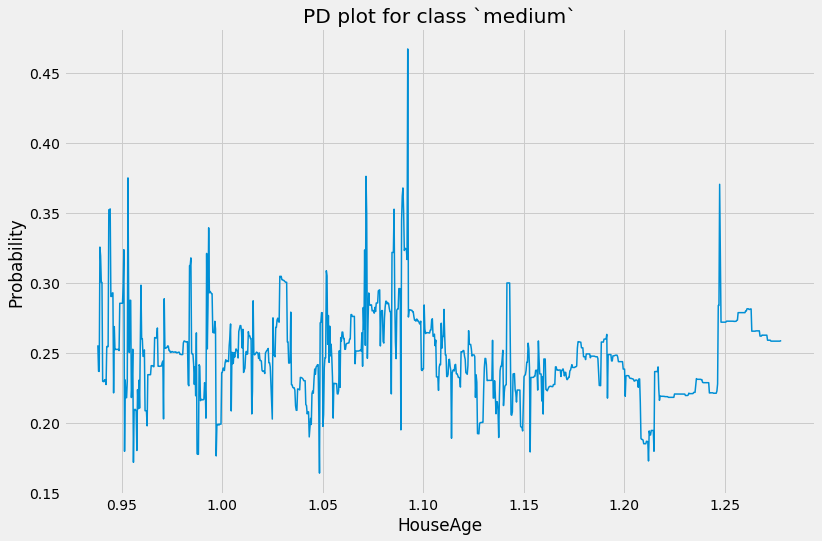

In [8]:
pd_plot.partial_dependence_plot_custom(gbrt=clf,
                              target_variable_name='AveBedrms',
                              label_name='high',
                              X=features_train,
                              grid_resolution=1000,
                              **plot_config)

In [9]:
plot_config = {'title': 'PD plot for class `low`', 
             'xlabel': 'Population', 
             'ylabel': 'Probability'}

(<matplotlib.figure.Figure at 0x1d8265c4fd0>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1d8280ffe48>)

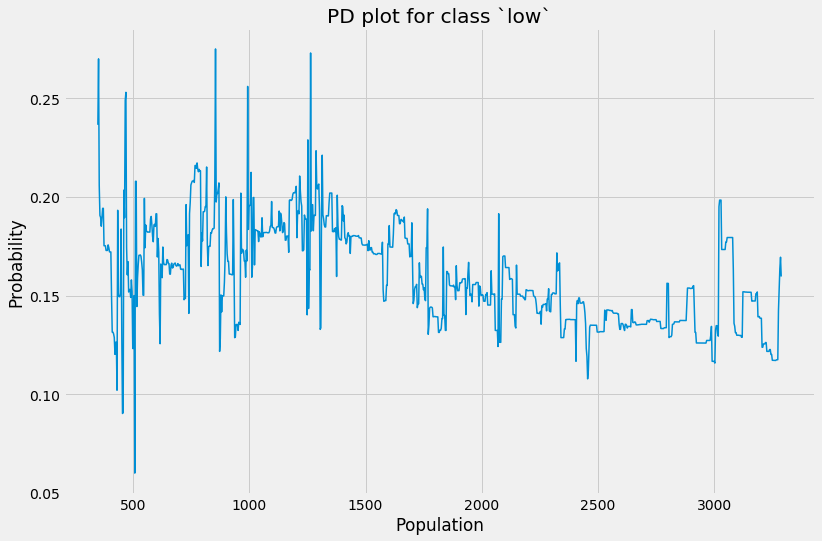

In [10]:
# Another example usage
pd_plot.partial_dependence_plot_custom(gbrt=clf,
                              target_variable_name='Population',
                              label_name='low',
                              X=features_train,
                              grid_resolution=1000,
                              **plot_config)